### This model will be trained purely by resampling the dataset; i.e, the datasets will be balanced.

In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk
import keras
import tensorflow  as tf
import keras_tuner
import seaborn as sns
import itertools
from sklearn.utils import resample
from keras.utils import to_categorical
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Add
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
try:
    for dirname, _, filenames in os.walk('ECG/inputs/'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
except Exception as e:
    print(f"An error occurred: {e}")

ECG/inputs/dataECG\mitbih_test.csv
ECG/inputs/dataECG\mitbih_train.csv
ECG/inputs/dataECG\ptbdb_abnormal.csv
ECG/inputs/dataECG\ptbdb_normal.csv


In [3]:
train_data = pd.read_csv('ECG/inputs/dataECG/mitbih_train.csv', header=None)
test_data = pd.read_csv('ECG/inputs/dataECG/mitbih_test.csv',header=None)


In [4]:
train_target = train_data[187]
test_target  = test_data [187]
train = train_data.drop(187,axis=1)
test = test_data.drop(187,axis=1)

In [5]:
expl_mitbih_train = train_target.copy()
expl_mitbih_test = test_target.copy()

In [6]:
expl_train = expl_mitbih_train.astype(int)

explor_train = expl_train.value_counts()

In [7]:
train_dataset = train_data[187].value_counts()
print(train_dataset)

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


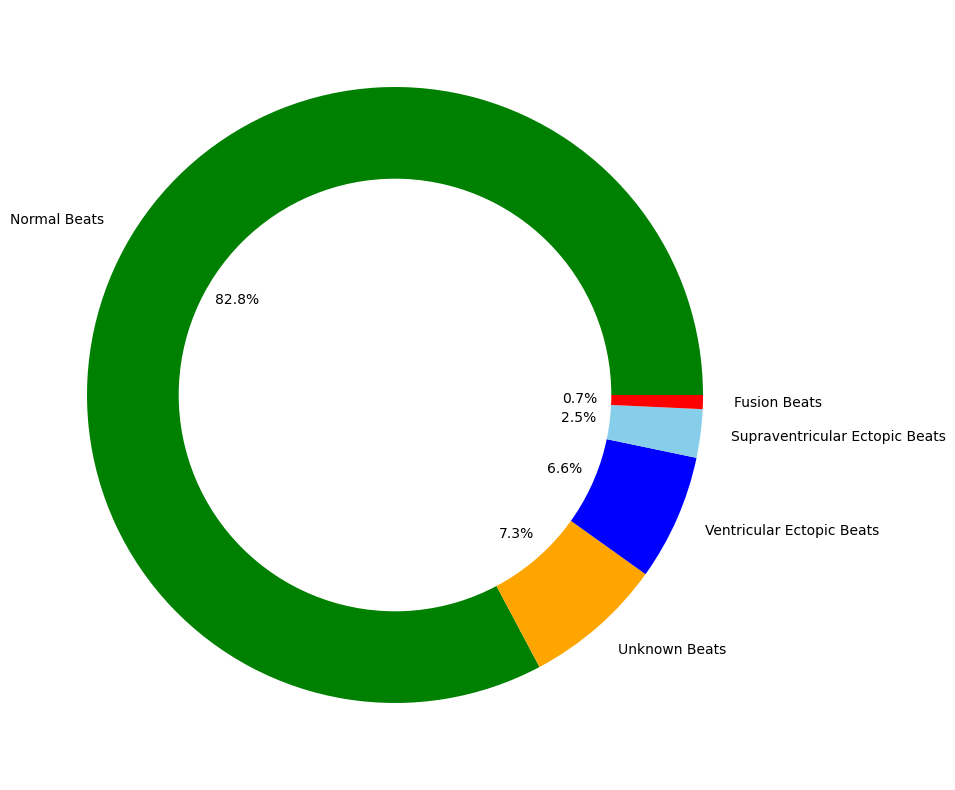

In [8]:
plt.figure(figsize = (10, 10))
circle = plt.Circle((0, 0), 0.7, color = "white")
plt.pie(explor_train, labels = ["Normal Beats", "Unknown Beats", "Ventricular Ectopic Beats", "Supraventricular Ectopic Beats", "Fusion Beats"], colors = ["green", "orange", "blue", "skyblue", "red"], autopct = "%1.1f%%")
k = plt.gcf()
k.gca().add_artist(circle)
plt.show()

Set some data apart from the test_data to form validation set.

In [9]:
test_data_lenght = len(test_data)

validation_size = 15000
test_size = test_data_lenght - validation_size

validation_data = test_data.iloc[ : validation_size]
test_set = test_data[validation_size : ]

In [10]:
val_dataset = validation_data[187].value_counts()
print(val_dataset)

187
0.0    15000
Name: count, dtype: int64


In [11]:
validation_data.shape

(15000, 188)

In [12]:
test_dataset = test_set[187].value_counts()
print(test_dataset)

187
0.0    3118
4.0    1608
2.0    1448
1.0     556
3.0     162
Name: count, dtype: int64


In [13]:
test_set.shape

(6892, 188)

`Dataset Balancing, by re-sampling the datasets.`

In [14]:
data_sample1 = train_data[train_data[187] == 1]
data_sample2 = train_data[train_data[187] == 2]
data_sample3 = train_data[train_data[187] == 3]
data_sample4 = train_data[train_data[187] == 4]
data_sample0 = (train_data[train_data[187] == 0]).sample(n = 20000, random_state = 100)

In [15]:
data1_upsample = resample(data_sample1, replace = True, n_samples = 20000, random_state = 120)
data2_upsample = resample(data_sample2, replace = True, n_samples = 20000, random_state = 140)
data3_upsample = resample(data_sample3, replace = True, n_samples = 20000, random_state = 160)
data4_upsample = resample(data_sample4, replace = True, n_samples = 20000, random_state = 120)

In [16]:
train_sampled = pd.concat([data_sample0, data1_upsample, data2_upsample, data3_upsample, data4_upsample])

In [17]:
balanced_dataset = train_sampled[187].value_counts()
print(balanced_dataset)

187
0.0    20000
1.0    20000
2.0    20000
3.0    20000
4.0    20000
Name: count, dtype: int64


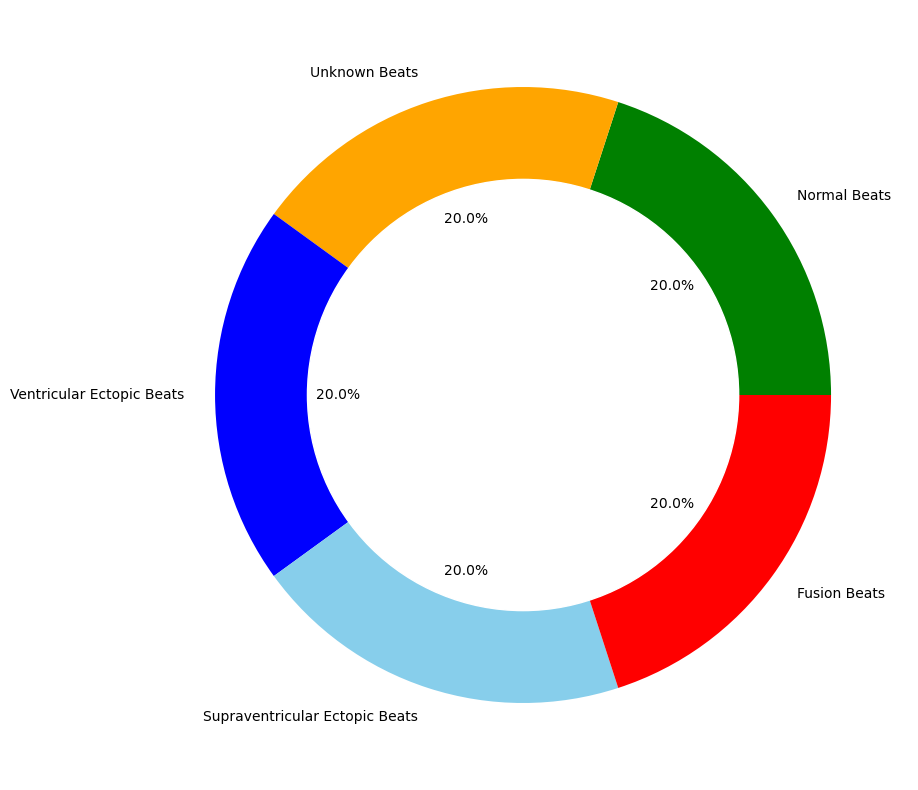

In [18]:
plt.figure(figsize = (10, 10))
circle = plt.Circle((0, 0), 0.7, color = "white")
plt.pie(balanced_dataset, labels = ["Normal Beats", "Unknown Beats", "Ventricular Ectopic Beats", "Supraventricular Ectopic Beats", "Fusion Beats"], colors = ["green", "orange", "blue", "skyblue", "red"], autopct = "%1.1f%%")
k = plt.gcf()
k.gca().add_artist(circle)
plt.show()

In [19]:
classes = train_sampled.groupby(187, group_keys = False).apply(lambda train_sampled : train_sampled.sample(1))

In [54]:
classes

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
9525,1.000000,0.849003,0.621083,0.424501,0.276353,0.165242,0.071225,0.017094,0.002849,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72779,0.789883,0.708171,0.159533,0.050584,0.120623,0.124514,0.070039,0.116732,0.167315,0.143969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
74836,0.839851,0.798883,0.713222,0.590317,0.415270,0.281192,0.227188,0.173184,0.152700,0.121043,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
80839,1.000000,0.741284,0.288073,0.126606,0.126606,0.058716,0.036697,0.066055,0.058716,0.040367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
85012,0.929152,0.873403,0.804878,0.742160,0.655052,0.542393,0.406504,0.272938,0.173055,0.124274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


Plot of different heartbeats in the dataset.

Text(0.5, 1.0, 'Normal Heart Beat')

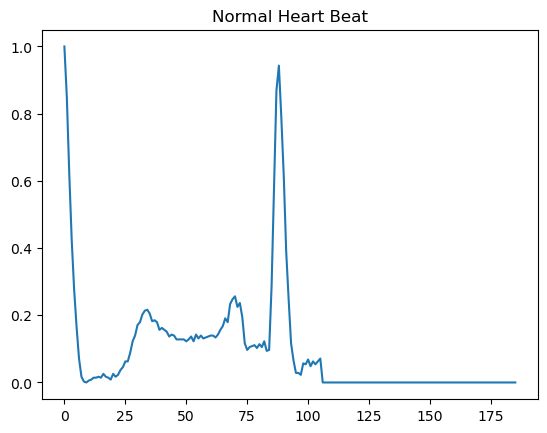

In [55]:
plt.plot(classes.iloc[0, : 186])
plt.title("Normal Heart Beat")

Text(0.5, 1.0, 'Supraventricular Ectopic Beat')

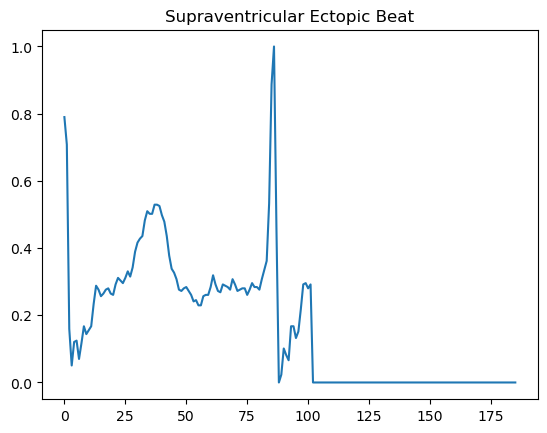

In [56]:
plt.plot(classes.iloc[1, : 186])
plt.title("Supraventricular Ectopic Beat")

Text(0.5, 1.0, 'Ventricular Ectopic Beat')

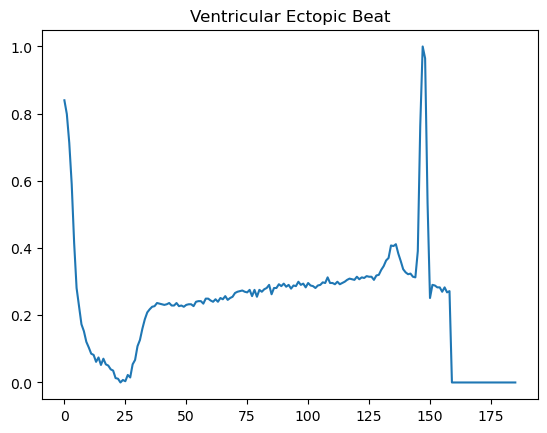

In [57]:
plt.plot(classes.iloc[2, : 186])
plt.title("Ventricular Ectopic Beat")

Text(0.5, 1.0, 'Fusion Beat')

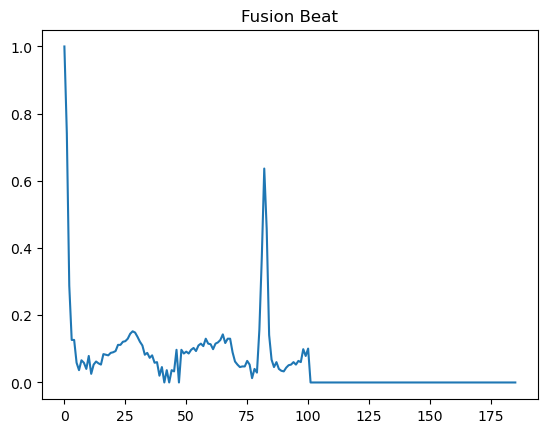

In [58]:
plt.plot(classes.iloc[3, : 186])
plt.title("Fusion Beat")

Text(0.5, 1.0, 'Unknown Beat')

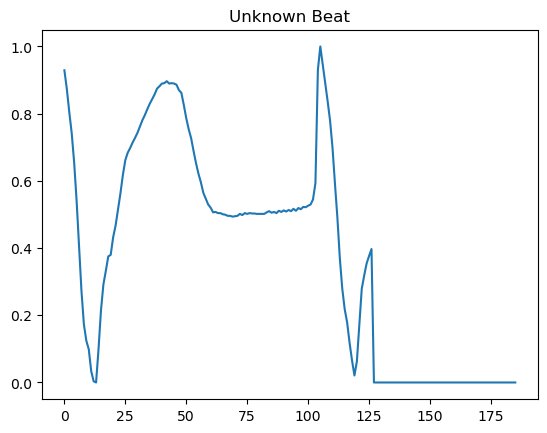

In [59]:
plt.plot(classes.iloc[4, : 186])
plt.title("Unknown Beat")

In [22]:
x_train_sampled = train_sampled.iloc[ : ,  : 186].values
x_test = test_data.iloc[ : ,  : 186].values
x_val = validation_data.iloc[ : , : 186].values

In [23]:
x_train_sampled

array([[1.        , 0.6555773 , 0.17025441, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.83433735, 0.63554215, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.68154764, 0.09821428, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.90755355, 0.85569334, 0.79255921, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.57028115, 0.59437752, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.7161572 , 0.69432312, ..., 0.        , 0.        ,
        0.        ]])

In [24]:
x_test

array([[1.        , 0.75826448, 0.11157025, ..., 0.        , 0.        ,
        0.        ],
       [0.90842491, 0.7838828 , 0.53113556, ..., 0.        , 0.        ,
        0.        ],
       [0.73008847, 0.21238938, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.96735907, 0.62017804, ..., 0.        , 0.        ,
        0.        ],
       [0.98412699, 0.5674603 , 0.60714287, ..., 0.        , 0.        ,
        0.        ],
       [0.97396964, 0.91323209, 0.86550975, ..., 0.        , 0.        ,
        0.        ]])

In [25]:
train_target = train_sampled[187]
#test_target = test_set[187]
test_target = test_data[187]
#validation_target = validation_data[187]

In [26]:
y_train_sampled = to_categorical(train_target)
y_test = to_categorical(test_target)
#y_val = to_categorical(validation_target)

`NOTE: Noise is not added to this, planning to carry out Data denoising later.`

In [27]:

x_test = x_test.reshape(len(x_test), x_test.shape[1], 1)
x_train_sampled = x_train_sampled.reshape(len(x_train_sampled), x_train_sampled.shape[1], 1)

#x_val = x_val.reshape(len(x_val), x_val[1], 1)

The Residual block

In [28]:
def residual_block(x, filters, kernel_size = 5, strides = 1):
    # Shortcut connection
    shortcut = x
    
    # First convolution layer
    x = Conv1D(filters, kernel_size = kernel_size, strides = strides, padding = "same", kernel_initializer = GlorotUniform())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolution layer
    x = Conv1D(filters, kernel_size = kernel_size, strides = strides, padding = "same", kernel_initializer = GlorotUniform())(x)
    x = BatchNormalization()(x)
    
    # Adjusting the shortcut connection with a 1x1 convolution
    shortcut = Conv1D(filters, kernel_size = 1, strides = strides, padding = "same")(shortcut)
    
    # Adding the shortcut to the main path
    x = Add()([x, shortcut])
    x = Activation("selu")(x)
    
    return x

In [29]:
input_shape = (x_train_sampled.shape)
class_num = len(classes)

In [30]:
class_num

5

In [31]:
input_shape = (x_train_sampled.shape[1], 1)

Model Architecture.

In [32]:
def build_model(hp):

    input_shape = (x_train_sampled.shape[1], 1)
    class_num = len(classes)
    model = tf.keras.Sequential()
    # Input layer
    input_layer = tf.keras.layers.Input(shape=input_shape)

    # Convolutional layers
    x = tf.keras.layers.Conv1D(
        filters = 64,
        kernel_size = 6,
        strides = 2,
        padding="same",
        kernel_initializer = tf.keras.initializers.GlorotUniform()
    )(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("selu")(x)
    x = tf.keras.layers.MaxPooling1D(pool_size = 3, padding = "same")(x)

    # Residual blocks
    for _ in range(hp.Int("num_residual_blocks", 2, 5)):
        x = residual_block(x, filters = 64)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling1D(pool_size = 2, padding = "same")(x)
        if hp.Boolean("Dropout_Residual_Blocks"):
            x = tf.keras.layers.Dropout(rate = 0.25)(x)

    for _ in range(hp.Int("num_residual_blocks", 2, 5)):
        x = residual_block(x, filters = 128)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling1D(pool_size = 2, padding = "same")(x)
        if hp.Boolean("Dropout_Residual_Blocks"):
            x = tf.keras.layers.Dropout(rate = 0.25)(x)

    x = residual_block(x, filters = 256)
    x = tf.keras.layers.MaxPooling1D(pool_size = 2, padding = "same")(x)

    # Flatten layer
    x = tf.keras.layers.Flatten()(x)

    # Dense layers
    for i in range(hp.Int("num_dense_layers", 1, 3)):
        x = tf.keras.layers.Dense(
            units = hp.Int(f"units_dense_{i}", min_value=32, max_value = 512, step = 32),
            activation = hp.Choice("activation_dense", ["relu", "selu"])
        )(x)
        if hp.Boolean("Dropout_Residual_Blocks"):
            x = tf.keras.layers.Dropout(rate = 0.25)(x)

    # Output layer
    model_output = tf.keras.layers.Dense(class_num, activation = "softmax")(x)

    # Compile the model
    model = tf.keras.Model(inputs = input_layer, outputs = model_output)
    learning_rate = hp.Float("learning_rate", min_value = 1e-4, max_value = 2e-2, sampling = "log")
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss = "categorical_crossentropy",
        metrics = ["accuracy"]
    )
    return model


In [33]:
build_model(keras_tuner.HyperParameters())

In [34]:
input_shape = (x_train_sampled.shape[1], 1)

In [35]:
class_num

5

In [36]:
tuner = keras_tuner.RandomSearch(
    hypermodel = build_model,
    objective = "val_accuracy",
    max_trials = 4,
    executions_per_trial = 2,
    overwrite = True,
    directory = "./",
    project_name = "mitbih_tuned",
)

In [37]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_residual_blocks (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
Dropout_Residual_Blocks (Boolean)
{'default': False, 'conditions': []}
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_dense_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_dense (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'selu'], 'ordered': False}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.02, 'step': None, 'sampling': 'log'}


In [38]:
tuner.search(
    x_train_sampled, y_train_sampled, 
    epochs = 3, 
    validation_data = (x_test, y_test),
    callbacks = [keras.callbacks.TensorBoard("./tbb2_logs")]
    )

Trial 4 Complete [00h 15m 12s]
val_accuracy: 0.9025671482086182

Best val_accuracy So Far: 0.9616298079490662
Total elapsed time: 00h 54m 37s


In [39]:
%load_ext tensorboard

%tensorboard --logdir ./tbb2_logs

In [40]:
models = tuner.get_best_models(num_models = 2)
best_model = models[0]

In [41]:
tuner.results_summary()

Results summary
Results in ./mitbih_tuned
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
num_residual_blocks: 2
Dropout_Residual_Blocks: False
num_dense_layers: 1
units_dense_0: 448
activation_dense: relu
learning_rate: 0.0006911619611935151
Score: 0.9616298079490662

Trial 3 summary
Hyperparameters:
num_residual_blocks: 3
Dropout_Residual_Blocks: True
num_dense_layers: 3
units_dense_0: 256
activation_dense: relu
learning_rate: 0.0009032379201197442
units_dense_1: 32
units_dense_2: 32
Score: 0.9025671482086182

Trial 0 summary
Hyperparameters:
num_residual_blocks: 2
Dropout_Residual_Blocks: False
num_dense_layers: 1
units_dense_0: 480
activation_dense: selu
learning_rate: 0.013936293278834685
Score: 0.8901196718215942

Trial 2 summary
Hyperparameters:
num_residual_blocks: 2
Dropout_Residual_Blocks: True
num_dense_layers: 1
units_dense_0: 480
activation_dense: relu
learning_rate: 0.00014385055123734987
Score: 0.8850493133068085


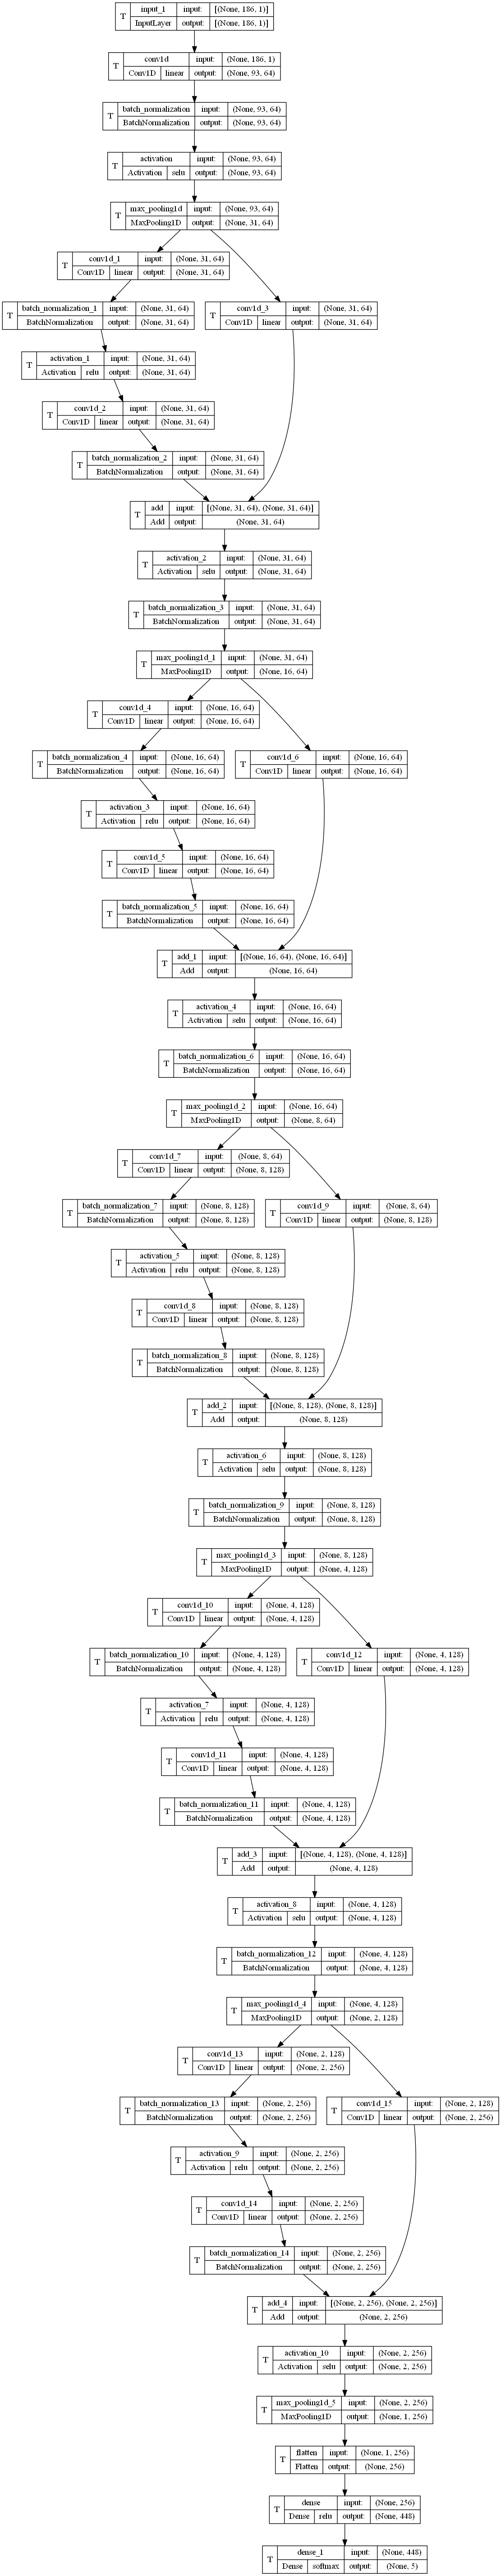

In [42]:
tf.keras.utils.plot_model(best_model,
                          to_file='modelv02a.png', 
                          show_layer_names=True,
                          show_layer_activations = True,
                          show_trainable = True,
                          show_shapes = True,
                          dpi=96)

In [43]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 186, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 93, 64)               448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 93, 64)               256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 93, 64)               0         ['batch_normalization[0][0

`Train Best Model with the datasets`

In [44]:
history = best_model.fit(
    x_train_sampled, y_train_sampled, 
    epochs = 10, 
    validation_data = (x_test, y_test),
    batch_size = 32,
    callbacks = [keras.callbacks.TensorBoard("./tbb2_logs")]
    )

Epoch 1/10
3125/3125 [==============================] - 140s 40ms/step - loss: 0.0529 - accuracy: 0.9823 - val_loss: 0.1128 - val_accuracy: 0.9686
Epoch 2/10
3125/3125 [==============================] - 129s 41ms/step - loss: 0.0424 - accuracy: 0.9862 - val_loss: 0.1460 - val_accuracy: 0.9639
Epoch 3/10
3125/3125 [==============================] - 126s 40ms/step - loss: 0.0371 - accuracy: 0.9878 - val_loss: 0.1046 - val_accuracy: 0.9704
Epoch 4/10
3125/3125 [==============================] - 126s 40ms/step - loss: 0.0316 - accuracy: 0.9899 - val_loss: 0.1053 - val_accuracy: 0.9758
Epoch 5/10
3125/3125 [==============================] - 113s 36ms/step - loss: 0.0280 - accuracy: 0.9910 - val_loss: 0.0863 - val_accuracy: 0.9813
Epoch 6/10
3125/3125 [==============================] - 117s 38ms/step - loss: 0.0267 - accuracy: 0.9917 - val_loss: 0.1226 - val_accuracy: 0.9721
Epoch 7/10
3125/3125 [==============================] - 119s 38ms/step - loss: 0.0245 - accuracy: 0.9923 - val_loss: 0

Model performance plots.

In [45]:
def model_plots(history):
    """ This function plots the model accuracy and loss. """
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy")
    plt.legend(["Train", "Validation"], loc = "upper left")
    plt.show()


    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Model Loss")
    plt.legend(["Train", "Validation"], loc = "upper left")
    plt.show()

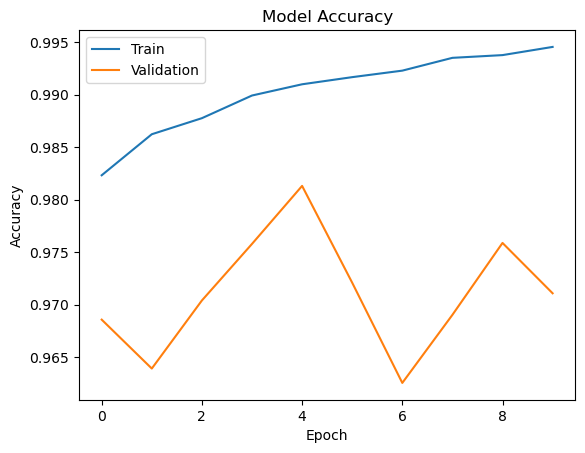

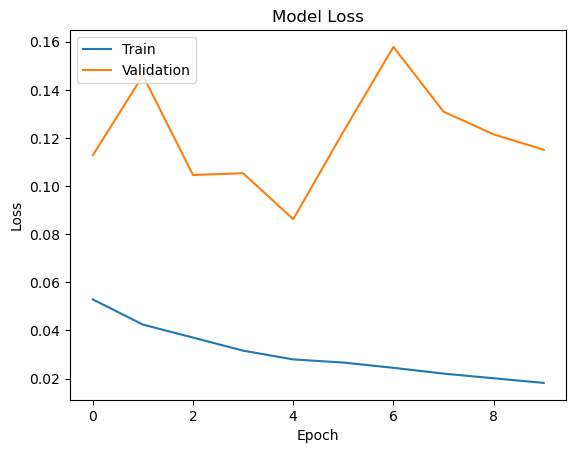

In [46]:
model_plots(history = history)

In [47]:
loss, accuracy = best_model.evaluate(x_test, y_test)
print(f"Test Accuracy is: {accuracy} and Test Loss is: {loss}")

685/685 [==============================] - 10s 14ms/step - loss: 0.1151 - accuracy: 0.9711
Test Accuracy is: 0.9710853099822998 and Test Loss is: 0.11508691310882568


In [48]:
y_pred = best_model.predict(x_test)

685/685 [==============================] - 10s 13ms/step


In [49]:

def plot_confusion_matrix (model, x_test, y_test, class_names):
    y_pred_classes = np.argmax(y_pred, axis = 1)
    conf_matrix = confusion_matrix(np.argmax(y_test, axis = 1), y_pred_classes)

    plt.figure(figsize = (10, 10))
    sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "YlGnBu", xticklabels = class_names, yticklabels = class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.show()

    print(classification_report(np.argmax(y_test, axis = 1), y_pred_classes, target_names = class_names))

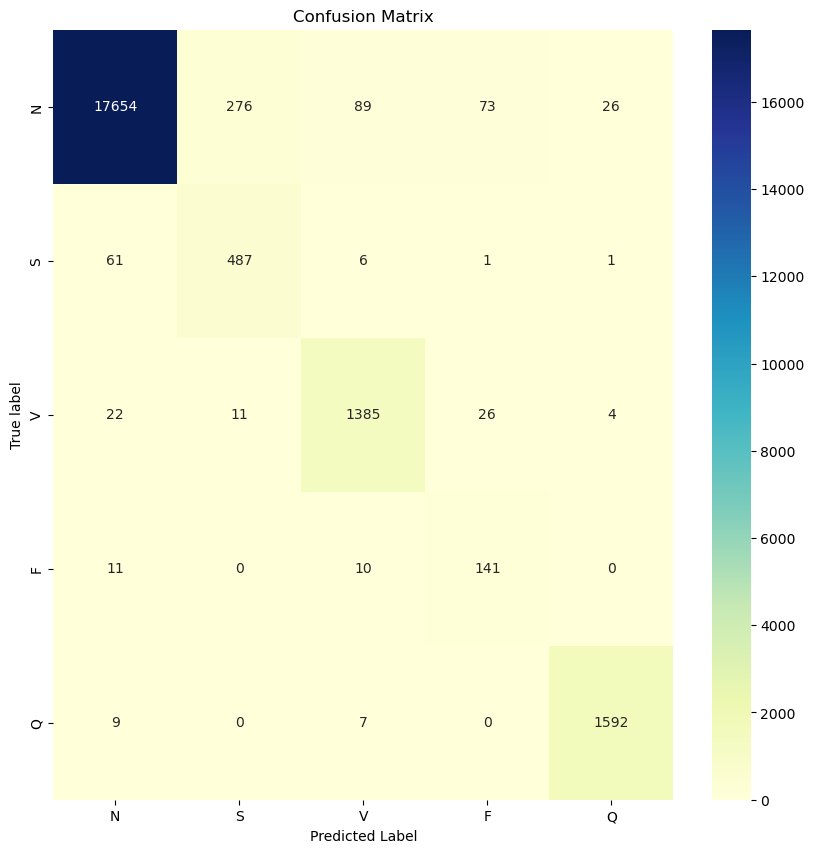

              precision    recall  f1-score   support

           N       0.99      0.97      0.98     18118
           S       0.63      0.88      0.73       556
           V       0.93      0.96      0.94      1448
           F       0.59      0.87      0.70       162
           Q       0.98      0.99      0.99      1608

    accuracy                           0.97     21892
   macro avg       0.82      0.93      0.87     21892
weighted avg       0.98      0.97      0.97     21892



In [50]:
class_names = ["N", "S", "V", "F", "Q"]

plot_confusion_matrix(best_model, x_test, y_test, class_names)

In [51]:
def plot_confusion_matrix(classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    y_pred_classes = np.argmax(y_pred, axis = 1)
    conf_matrix = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
    np.set_printoptions(precision = 2)
    
    if normalize:
        cm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    
    
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
    print(classification_report(np.argmax(y_test, axis = 1), y_pred_classes, target_names = class_names))


Normalized confusion matrix


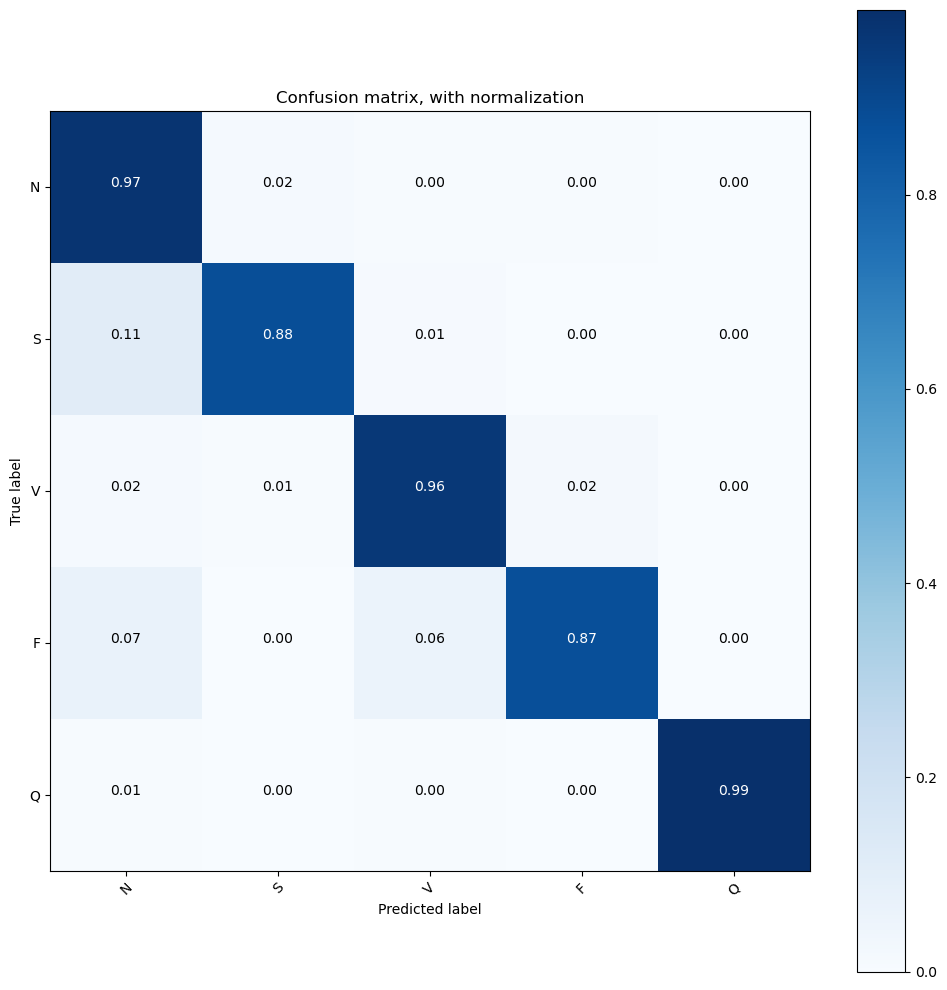

              precision    recall  f1-score   support

           N       0.99      0.97      0.98     18118
           S       0.63      0.88      0.73       556
           V       0.93      0.96      0.94      1448
           F       0.59      0.87      0.70       162
           Q       0.98      0.99      0.99      1608

    accuracy                           0.97     21892
   macro avg       0.82      0.93      0.87     21892
weighted avg       0.98      0.97      0.97     21892



In [52]:
plot_confusion_matrix(classes = class_names, normalize = True,
                      title="Confusion matrix, with normalization")


`Safe the Best Model`

In [53]:
model_dir = "trained_models"

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
best_model.save(os.path.join(model_dir, "projectv02aModel.h5"))

c:\Users\DELL\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# To load the model in future;

#loaded_model = tf.keras.models.load_model(os.path.join(model_dir, "projectv02aModel.h5"))